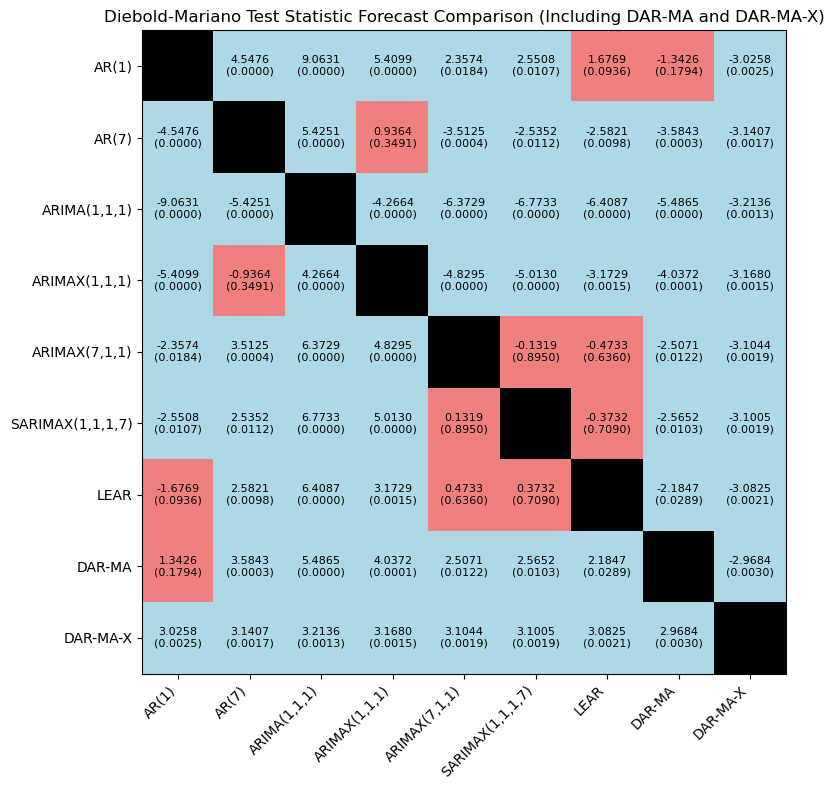

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import norm

# Define the Newey-West bandwidth function
def newey_west_bandwidth(T):
    return int(np.floor(4 * (T / 100) ** (2 / 9)))

# Diebold-Mariano test function
def diebold_mariano_test(actual, forecast1, forecast2, loss="squared", significance_level=0.05):
    actual, forecast1, forecast2 = np.array(actual), np.array(forecast1), np.array(forecast2)
    
    # Compute forecast errors
    e1 = actual - forecast1
    e2 = actual - forecast2
    
    # Compute loss differentials
    if loss == "squared":
        d = (e1 ** 2) - (e2 ** 2)
    elif loss == "absolute":
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("Loss function must be 'squared' or 'absolute'")
    
    # Mean of the loss differential
    d_mean = np.mean(d)
    
    # Determine the Newey-West optimal lag
    T = len(d)
    optimal_lag = newey_west_bandwidth(T)
    
    # HAC variance estimation using Bartlett weights
    gamma = [np.sum(d[:T - lag] * d[lag:]) / T for lag in range(optimal_lag + 1)]
    hac_var = gamma[0] + 2 * sum((1 - lag / (optimal_lag + 1)) * gamma[lag] for lag in range(1, optimal_lag + 1))
    
    # Diebold-Mariano statistic
    dm_stat = d_mean / np.sqrt(hac_var / T)
    
    # p-value for two-sided test
    p_value = 2 * (1 - norm.cdf(np.abs(dm_stat)))
    
    return dm_stat, p_value

# Load the combined_predictions.csv file
data = pd.read_csv('combined_predictions.csv')

# Extract the actual and forecast values
actual = data['Actual'].values
forecasts = [data[col].values for col in data.columns if col != 'Actual']

# Replace column names with custom names for forecasts
forecast_names = [
    'AR(1)',
    'AR(7)',
    'ARIMA(1,1,1)',
    'ARIMAX(1,1,1)',
    'ARIMAX(7,1,1)',
    'SARIMAX(1,1,1,7)'
]

# Load the combined_predictions_ml.csv file
dataml = pd.read_csv('combined_predictions_ml.csv')

# Extract the LEAR forecast values
forecastsml = [dataml[col].values for col in dataml.columns if col != 'Actual']

# Replace column names with custom names for ML forecasts
forecast_namesml = ['LEAR']

# Load the combined_predictions_darma.csv file
datadarma = pd.read_csv('combined_predictions_darma.csv')

# Extract the DAR-MA and DAR-MA-X forecast values (assuming 'DAR-MA' and 'DAR-MA-X' are the forecast columns)
darma_forecast = [datadarma[col].values for col in datadarma.columns if col != 'Actual']

# Update the forecast names to include both DAR-MA and DAR-MA-X
darma_name = ['DAR-MA', 'DAR-MA-X']

# Remove the first 48 observations from all time series
actual = actual[48:]
forecasts = [f[48:] for f in forecasts]
forecastsml = [f[48:] for f in forecastsml]
darma_forecast = [f[48:] for f in darma_forecast]

# Align lengths of forecasts for comparisons with DAR-MA
min_index = len(darma_forecast[0])  # Find the length of DAR-MA data
actual_aligned = actual[-min_index:]  # Trim actual data
forecasts_aligned = [f[-min_index:] for f in forecasts]  # Trim all forecasts to match DAR-MA length
forecastsml_aligned = [f[-min_index:] for f in forecastsml]  # Align ML forecasts
darma_forecast_aligned = [f[-min_index:] for f in darma_forecast]  # Align DAR-MA forecasts

# Combine all forecasts and names
all_forecasts = forecasts_aligned + forecastsml_aligned + darma_forecast_aligned
all_forecast_names = forecast_names + forecast_namesml + darma_name

# Create matrices for all forecasts
dm_matrix = np.zeros((len(all_forecasts), len(all_forecasts)))
p_value_matrix = np.zeros((len(all_forecasts), len(all_forecasts)))

# Fill the matrices with DM test results
for i in range(len(all_forecasts)):
    for j in range(len(all_forecasts)):
        if i != j:
            dm_stat, p_value = diebold_mariano_test(actual_aligned, all_forecasts[i], all_forecasts[j])
            dm_matrix[i, j] = dm_stat
            p_value_matrix[i, j] = p_value

# Define the critical value
significance_level = 0.05
critical_value = norm.ppf(1 - significance_level / 2)

# Create a color matrix based on the critical value
color_matrix = np.zeros(dm_matrix.shape)
for i in range(dm_matrix.shape[0]):
    for j in range(dm_matrix.shape[1]):
        if i != j:
            if np.abs(dm_matrix[i, j]) <= critical_value:
                color_matrix[i, j] = 0  # light grey
            else:
                color_matrix[i, j] = 1  # dark grey
        else:
            color_matrix[i, j] = 2  # black for diagonal

# Define custom colormap: 0 for lightred, 1 for lightblue, and 2 for black
cmap = ListedColormap(['lightcoral', 'lightblue', 'black'])

# Create the heatmap using plt
plt.figure(figsize=(10, 8))  # Adjust size for larger matrix

# Create the matrix plot using imshow, with the custom color mapping
cax = plt.imshow(color_matrix, cmap=cmap, interpolation='nearest')

# Annotate the plot
for i in range(dm_matrix.shape[0]):
    for j in range(dm_matrix.shape[1]):
        if i != j:  # Don't annotate the diagonal
            dm_stat = dm_matrix[i, j]
            p_value = p_value_matrix[i, j]
            plt.text(j, i, f"{dm_stat:.4f}\n({p_value:.4f})", ha='center', va='center', color='black', fontsize=8)

# Add labels
plt.xticks(np.arange(len(all_forecast_names)), all_forecast_names, rotation=45, ha="right")
plt.yticks(np.arange(len(all_forecast_names)), all_forecast_names)

# Add title, colorbar, and improve layout
plt.title("Diebold-Mariano Test Statistic Forecast Comparison (Including DAR-MA and DAR-MA-X)")
plt.tight_layout()
plt.show()


Positive numbers in means the model on the y-axis has higer errors. so AR(1) has hugher errors then all models. And ARIMA(1,1,1) is better than all models, consistent with out-of-sample measures.